<a href="https://colab.research.google.com/github/FinleyMM/NBA_athlete_scouting/blob/main/FinleyMichael.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488490 sha256=044d4d6fbad1e886dd3626c1a236faf1e2e8051685812982b87c89d8cb401928
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("CW") \
    .getOrCreate()

# Now you can use the spark variable to interact with Spark

# Step 2: Load the dataset into a PySpark DataFrame
# Assuming you have the dataset file named 'nba_player_stats.csv'
data = "/content/Book1.csv"
df = spark.read.csv(data, header=True, inferSchema=True)
# Check the column names and DataFrame schema
print("Column Names:")
print(df.columns)
print("\nDataFrame Schema:")
df.printSchema()

# Step 3: Select relevant performance metrics as features for clustering
# Make sure the column names match the actual column names
feature_cols = ["PTS", "AST", "TRB", "STL", "BLK"]


Column Names:
['Rk', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']

DataFrame Schema:
root
 |-- Rk: integer (nullable = true)
 |-- Player: string (nullable = true)
 |-- Pos: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tm: string (nullable = true)
 |-- G: integer (nullable = true)
 |-- GS: integer (nullable = true)
 |-- MP: double (nullable = true)
 |-- FG: double (nullable = true)
 |-- FGA: double (nullable = true)
 |-- FG%: double (nullable = true)
 |-- 3P: double (nullable = true)
 |-- 3PA: double (nullable = true)
 |-- 3P%: double (nullable = true)
 |-- 2P: double (nullable = true)
 |-- 2PA: double (nullable = true)
 |-- 2P%: double (nullable = true)
 |-- eFG%: double (nullable = true)
 |-- FT: double (nullable = true)
 |-- FTA: double (nullable = true)
 |-- FT%: double (nullable = true)
 |-- ORB: double (nullabl

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA

# Create a SparkSession
spark = SparkSession.builder \
    .appName("NBA PCA Example") \
    .getOrCreate()

# Load the NBA dataset
df = spark.read.csv("/content/Book1.csv", header=True, inferSchema=True)

# Selecting relevant columns for PCA
selected_columns = ["Age", "G", "GS", "MP", "FG", "FGA", "FG%", "3PA", "3P%", "2P", "2PA", "2P%", "FT", "FTA", "FT%", "ORB", "DRB", "TRB", "AST", "STL", "BLK", "TOV", "PF", "PTS"]

# Drop any rows with missing values
df = df.dropna()

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=selected_columns, outputCol="features")
df = assembler.transform(df)

# Apply PCA
num_principal_components = 2  # Specify the number of principal components you want
pca = PCA(k=num_principal_components, inputCol="features", outputCol="pca_features")
model = pca.fit(df)

# Transform the data using the PCA model
df_pca = model.transform(df)

# Show the PCA features
df_pca.select("pca_features").show(truncate=False)

# Show the explained variance ratio
print("Explained Variance Ratio:", model.explainedVariance.toArray())

+-----------------------------------------+
|pca_features                             |
+-----------------------------------------+
|[-51.8218361037152,-28.3771384986581]    |
|[-66.37264829776218,0.2945171247001319]  |
|[-115.9372808073941,-1.0528713191369903] |
|[-60.538142270724606,-26.470738759247933]|
|[-71.4191634703974,-40.802761414623475]  |
|[-45.435652325356884,-38.80896868626085] |
|[-30.695281615540857,-21.16460303722113] |
|[-20.45094686867755,-12.825841043916567] |
|[-104.92909491355347,-6.728714790633191] |
|[-103.90440898882218,-2.3326530921778215]|
|[-54.17333095875641,-34.211858297875466] |
|[-86.59663435877194,-17.938029644727116] |
|[-102.52732562896867,4.150399915719483]  |
|[-25.71863006640061,-26.465935055159875] |
|[-51.67797680214418,-34.90850685617084]  |
|[-103.73720976845803,-1.1264908102220161]|
|[-18.39150419700327,-10.607460640523918] |
|[-7.978673490438878,-7.410044188867624]  |
|[-13.63603130615379,-0.448576711444888]  |
|[-86.35218121075648,-27.2861894

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Assume you have already performed PCA and stored the result in a column named 'features'

# Create KMeans instance
kmeans = KMeans().setK(2).setSeed(42)

# Fit the model on the PCA-transformed data
model = kmeans.fit(df)

# Make predictions
predictions = model.transform(df)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette_score = evaluator.evaluate(predictions)
print("Silhouette Score:", silhouette_score)

# Show the result
centers = model.clusterCenters()
print("Cluster Centers:")
for center in centers:
    print(center)


Silhouette Score: 0.7208784584505643
Cluster Centers:
[25.81278539 32.97488584  4.32420091 14.69315068  2.18082192  4.7696347
  0.45094292  2.06780822  0.30935845  1.45593607  2.70228311  0.51768721
  0.81484018  1.08972603  0.68318493  0.65479452  1.90045662  2.5543379
  1.35388128  0.46438356  0.27511416  0.75684932  1.3739726   5.9       ]
[26.4354067  67.47368421 54.70813397 29.68851675  5.58038278 11.5937799
  0.48633971  4.33588517  0.33260287  3.99569378  7.25837321  0.54900478
  2.60143541  3.27464115  0.7827799   1.22727273  4.13205742  5.35550239
  3.43779904  0.89138756  0.56842105  1.74497608  2.26172249 15.34736842]


In [ ]:
pandas_df = df.toPandas()
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


X = pandas_df['features'].tolist()
y = pandas_df['Pos']

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#KNN classification
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

#Predictions
y_pred = knn.predict(X_test)

#Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.50


In [ ]:
# prompt: Give me performance metrics of the model

from sklearn.metrics import classification_report, confusion_matrix

# Generate classification report
print(classification_report(y_test, y_pred))

# Generate confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           C       0.59      0.88      0.71        25
          PF       0.33      0.36      0.35        22
       PF-SF       0.00      0.00      0.00         2
          PG       0.60      0.75      0.67        28
          SF       0.50      0.36      0.42        25
          SG       0.36      0.24      0.29        34

    accuracy                           0.50       136
   macro avg       0.40      0.43      0.40       136
weighted avg       0.47      0.50      0.47       136

Confusion Matrix:
[[22  2  0  0  0  1]
 [ 6  8  0  1  3  4]
 [ 0  2  0  0  0  0]
 [ 1  1  0 21  0  5]
 [ 3  6  0  3  9  4]
 [ 5  5  0 10  6  8]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Load the dataset into a PySpark DataFrame with the correct delimiter
file_path = "/content/Book1.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True, sep=",")

# Drop rows with missing values
df = df.na.drop(subset=feature_cols)


In [ ]:
# Extract the concatenated string of column names
columns_string = 'Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS'

# Extract the concatenated string of column names
columns_string = 'Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS'

# Split the string into individual column names using the comma delimiter
column_names = columns_string.split(',')

# Now you have a list of column names
print(column_names)
# Drop rows with missing values
df = df.na.drop(subset=column_names)

['Rk', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']
DataFrame[Rk: int, Player: string, Pos: string, Age: int, Tm: string, G: int, GS: int, MP: double, FG: double, FGA: double, FG%: double, 3P: double, 3PA: double, 3P%: double, 2P: double, 2PA: double, 2P%: double, eFG%: double, FT: double, FTA: double, FT%: double, ORB: double, DRB: double, TRB: double, AST: double, STL: double, BLK: double, TOV: double, PF: double, PTS: double]


<bound method DataFrame.describe of DataFrame[Rk: int, Player: string, Pos: string, Age: int, Tm: string, G: int, GS: int, MP: double, FG: double, FGA: double, FG%: double, 3P: double, 3PA: double, 3P%: double, 2P: double, 2PA: double, 2P%: double, eFG%: double, FT: double, FTA: double, FT%: double, ORB: double, DRB: double, TRB: double, AST: double, STL: double, BLK: double, TOV: double, PF: double, PTS: double]>

Index(['Player', 'PTS', 'AST', 'prediction'], dtype='object')


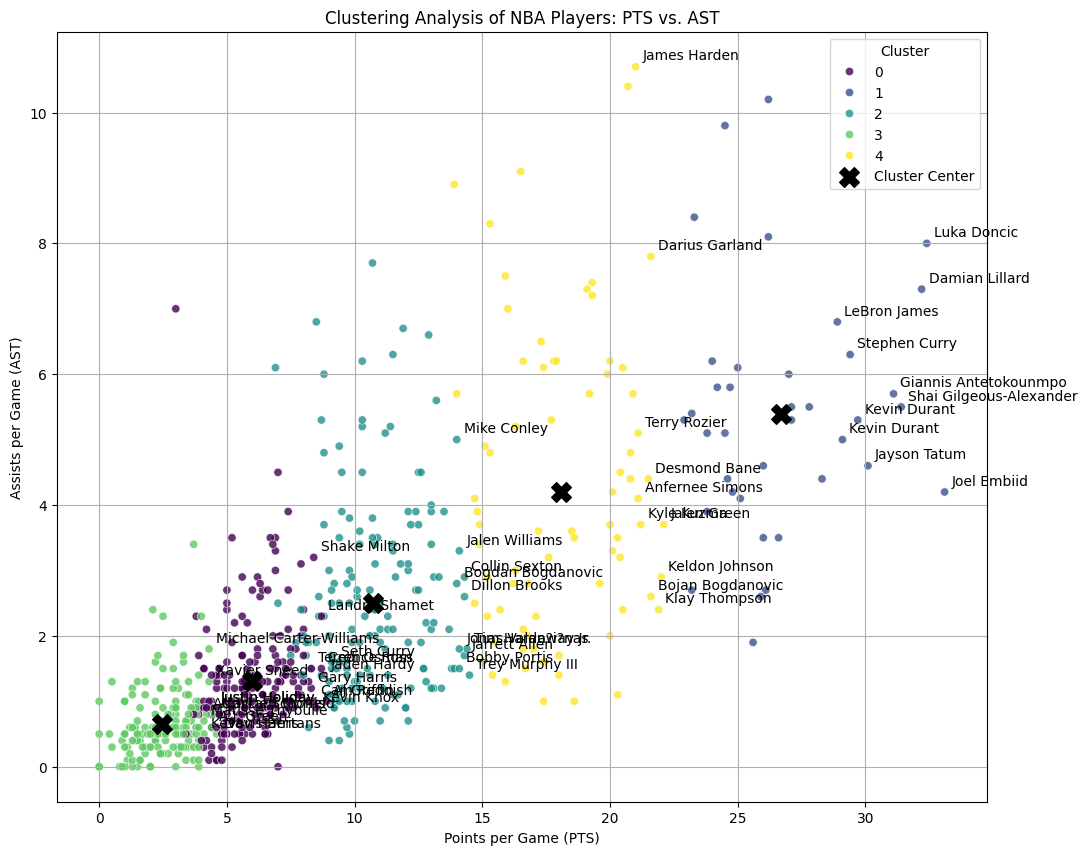

In [ ]:
# Convert predictions DataFrame to Pandas DataFrame for visualization
predictions_pd = predictions.select("Player", "PTS", "AST", "prediction").toPandas()
import seaborn as sns

# Check the column names in the predictions_pd DataFrame
print(predictions_pd.columns)

# Plotting
plt.figure(figsize=(12, 10))

# Check if the column names are correctly specified and present in the DataFrame
if "PTS" in predictions_pd.columns and "AST" in predictions_pd.columns:
    # Define a colormap
    cmap = sns.color_palette("viridis", as_cmap=True)

    # Scatter plot with color mapping
    sns.scatterplot(data=predictions_pd, x="PTS", y="AST", hue="prediction", palette=cmap, alpha=0.8)

    # Annotate specific data points (e.g., top 3 players in each cluster)
    for cluster, players in cluster_players.items():
        cluster_data = predictions_pd[predictions_pd["prediction"] == int(cluster.split()[1])]
        top_players = cluster_data.sort_values(by=["PTS", "AST"], ascending=False).head(10)
        for i, player in top_players.iterrows():
            plt.annotate(player["Player"], (player["PTS"], player["AST"]), textcoords="offset points", xytext=(5,5), ha="left")

    # Plot cluster centers
    plt.scatter(cluster_centers["PTS"], cluster_centers["AST"], marker="X", s=200, c="black", label="Cluster Center")

    plt.xlabel("Points per Game (PTS)")
    plt.ylabel("Assists per Game (AST)")
    plt.title("Clustering Analysis of NBA Players: PTS vs. AST")
    plt.legend(title="Cluster")
    plt.grid(True)
    plt.show()
else:
    print("The DataFrame does not contain the columns 'PTS' and 'AST'. Please verify the column names.")


In [ ]:
#Import necessary libraries
import pandas as pd

#Convert predictions DataFrame to Pandas DataFrame for further analysis
predictions_pd = predictions.select("Player", "prediction").toPandas()

#Create an empty dictionary to store players for each cluster
cluster_players = {}

#Iterate over each cluster
for cluster in range(num_clusters):
    #Filter players belonging to the current cluster
    cluster_data = predictions_pd[predictions_pd["prediction"] == cluster]

    #Sample 10 players from the cluster (if available)
    sample_players = cluster_data["Player"].sample(min(10, len(cluster_data)))

    #Store the sampled players in the dictionary
    cluster_players[f"Cluster {cluster}"] = sample_players.tolist()

#Print the sampled players for each cluster
for cluster, players in cluster_players.items():
    print(f"{cluster}:")
    for player in players:
        print(player)
    print()


Cluster 0:
Isaiah Livers
Jonathan Isaac
Jeff Green
Day'Ron Sharpe
Jaxson Hayes
Jordan Goodwin
Devonte' Graham
Cory Joseph
AJ Griffin
George Hill

Cluster 1:
Stephen Curry
Brandon Ingram
Luka Doncic
Zion Williamson
Kevin Durant
DeMar DeRozan
Anthony Davis
Pascal Siakam
Zach LaVine
De'Aaron Fox

Cluster 2:
Dennis Smith Jr.
Grant Williams
Jalen Suggs
Talen Horton-Tucker
Jarred Vanderbilt
Kelly Olynyk
Daniel Gafford
Derrick White
Mason Plumlee
Thomas Bryant

Cluster 3:
Usman Garuba
Damian Jones
Sandro Mamukelashvili
Kessler Edwards
Max Christie
Joe Wieskamp
Jamaree Bouyea
JD Davison
Leandro Bolmaro
Kennedy Chandler

Cluster 4:
Norman Powell
P.J. Washington
Chris Paul
Louis King
Cameron Johnson
Fred VanVleet
Mikal Bridges
Khris Middleton
Alperen Sengun
Tyrese Maxey



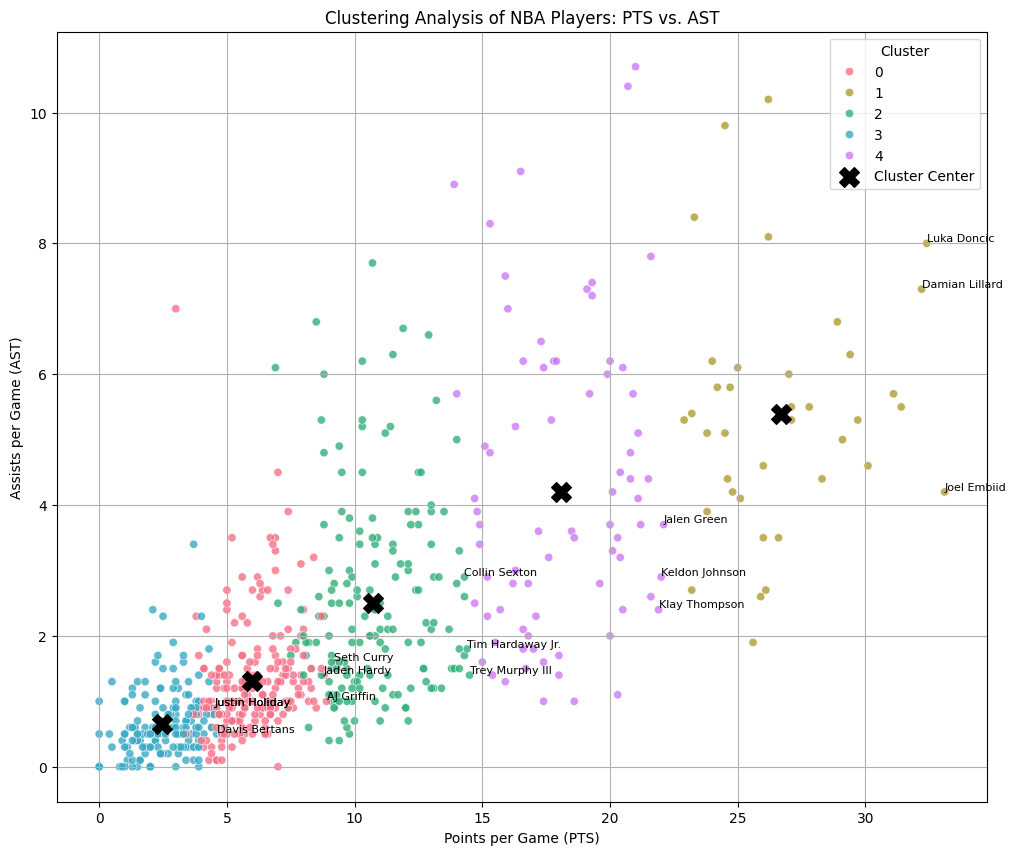

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert predictions DataFrame to Pandas DataFrame for visualization
predictions_pd = predictions.select("Player", "PTS", "AST", "prediction").toPandas()

# Define a custom color palette
palette = sns.color_palette("husl", num_clusters)

# Plotting
plt.figure(figsize=(12, 10))

# Scatter plot with color mapping
sns.scatterplot(data=predictions_pd, x="PTS", y="AST", hue="prediction", palette=palette, alpha=0.8)

# Annotate specific data points (e.g., top players in each cluster)
for cluster in range(num_clusters):
    cluster_data = predictions_pd[predictions_pd["prediction"] == cluster]
    top_players = cluster_data.sort_values(by=["PTS", "AST"], ascending=False).head(3)
    for i, player in top_players.iterrows():
        plt.text(player["PTS"], player["AST"], player["Player"], ha='left', va='bottom', fontsize=8)

# Plot cluster centers
plt.scatter(cluster_centers["PTS"], cluster_centers["AST"], marker="X", s=200, c="black", label="Cluster Center")

plt.xlabel("Points per Game (PTS)")
plt.ylabel("Assists per Game (AST)")
plt.title("Clustering Analysis of NBA Players: PTS vs. AST")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()


Root Mean Squared Error (RMSE) on test data: 0.07254862770893133
Coefficients: [0.0005946178309765515,0.00036339995559559824,0.0001263043313294459,-0.002299676966932791,1.8098105192919822,0.08963127241148025,0.12392304077746458,1.1313762280117283,-0.06397957328684589,0.026899278807103823,0.1989376756617689,-0.09220293332521436,-0.09168081250970903,0.9710533558097092,0.020809659086456878,0.006327197567224447,-0.010529406242761958,-0.00784592906331666,0.006604306962551918,-0.0013872131015743182,0.021744734095140664,0.03084006566126728,0.0032992298350468167,-0.004831028798825587]
Intercept: -0.045754507275927274


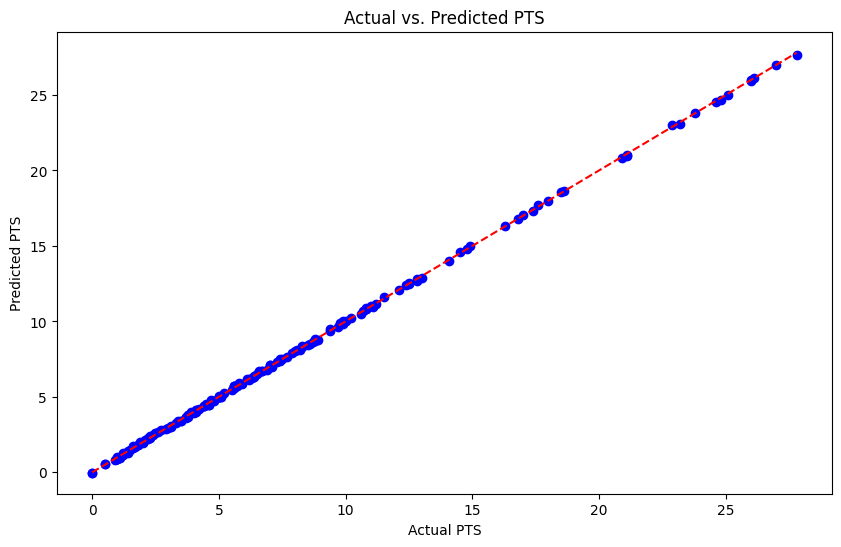

In [ ]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Create a SparkSession
spark = SparkSession.builder \
    .appName("NBA Linear Regression") \
    .getOrCreate()

# Load the dataset
df = spark.read.csv("/content/Book1.csv", header=True, inferSchema=True)

# Selecting relevant columns for linear regression
selected_columns = ["Age", "G", "GS", "MP", "FG", "FGA", "FG%", "3P", "3PA", "3P%", "2P", "2PA", "2P%", "FT", "FTA", "FT%", "ORB", "DRB", "TRB", "AST", "STL", "BLK", "TOV", "PF", "PTS"]

# Drop any rows with missing values
df = df.dropna()

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=selected_columns[:-1], outputCol="features")
df = assembler.transform(df)

# Select the feature column and the target column
data = df.select("features", "PTS")

# Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.7, 0.3], seed=42)

# Initialize the linear regression model
lr = LinearRegression(featuresCol="features", labelCol="PTS")

# Train the linear regression model
lr_model = lr.fit(train_data)

# Make predictions on the test data
predictions = lr_model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="PTS", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data:", rmse)

# Print the coefficients and intercept
print("Coefficients:", lr_model.coefficients)
print("Intercept:", lr_model.intercept)
import matplotlib.pyplot as plt
import numpy as np

# Extract actual and predicted values
actual_values = np.array(predictions.select("PTS").collect())
predicted_values = np.array(predictions.select("prediction").collect())

# Plotting
plt.figure(figsize=(10, 6))

plt.scatter(actual_values, predicted_values, color='blue')
plt.plot([0, np.max(actual_values)], [0, np.max(actual_values)], color='red', linestyle='--')

plt.title('Actual vs. Predicted PTS')
plt.xlabel('Actual PTS')
plt.ylabel('Predicted PTS')

plt.show()

# Stop the SparkSession
spark.stop()


Root Mean Squared Error (RMSE) on test data: 0.14839029284820038
Coefficients: [0.15580586296249432,0.002106362671675341,0.026164897442113727,0.0003806233465532403,-0.0013843250588123554]
Intercept: 0.08524296902621809


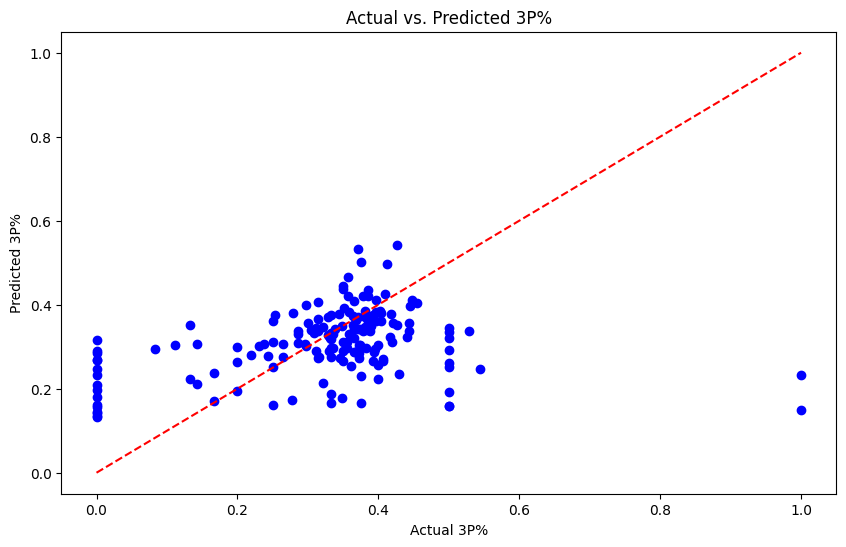

In [ ]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Create a SparkSession
spark = SparkSession.builder \
    .appName("NBA Linear Regression") \
    .getOrCreate()

# Load the dataset
df = spark.read.csv("/content/Book1.csv", header=True, inferSchema=True)

# Selecting relevant columns for linear regression
selected_columns = ["FT%",'Age','3PA','G', 'GS', 'MP']

# Drop any rows with missing values
df = df.dropna()

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=selected_columns[:-1], outputCol="features")
df = assembler.transform(df)

# Select the feature column and the target column
data = df.select("features", "3P%")

# Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.7, 0.3], seed=42)

# Initialize the linear regression model
lr = LinearRegression(featuresCol="features", labelCol="3P%")

# Train the linear regression model
lr_model = lr.fit(train_data)

# Make predictions on the test data
predictions = lr_model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="3P%", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data:", rmse)

# Print the coefficients and intercept
print("Coefficients:", lr_model.coefficients)
print("Intercept:", lr_model.intercept)
import matplotlib.pyplot as plt
import numpy as np

# Extract actual and predicted values
actual_values = np.array(predictions.select("3P%").collect())
predicted_values = np.array(predictions.select("prediction").collect())

# Plotting
plt.figure(figsize=(10, 6))

plt.scatter(actual_values, predicted_values, color='blue')
plt.plot([0, np.max(actual_values)], [0, np.max(actual_values)], color='red', linestyle='--')

plt.title('Actual vs. Predicted 3P%')
plt.xlabel('Actual 3P%')
plt.ylabel('Predicted 3P%')

plt.show()

# Stop the SparkSession
spark.stop()


Root Mean Squared Error (RMSE) on test data: 0.14839029284820038
Coefficients: [0.15580586296249432,0.002106362671675341,0.026164897442113727,0.0003806233465532403,-0.0013843250588123554]
Intercept: 0.08524296902621809


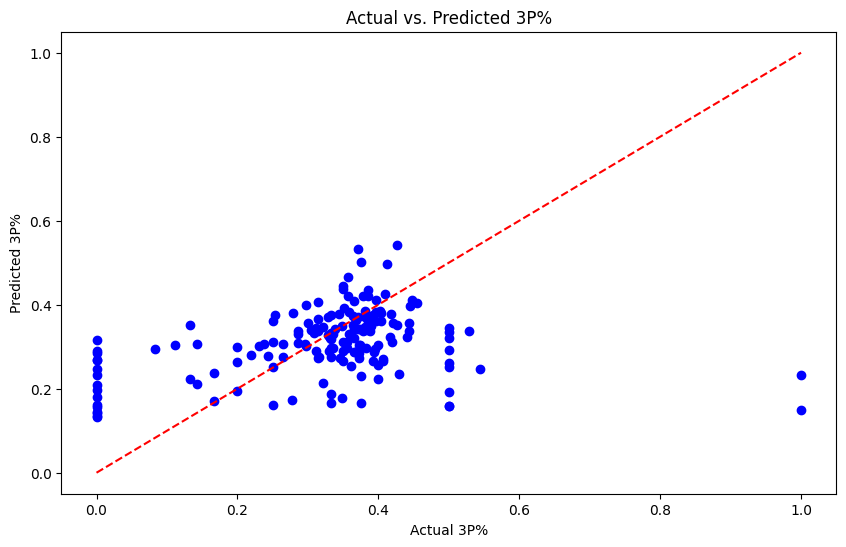

In [ ]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import numpy as np

# Create a SparkSession
spark = SparkSession.builder \
    .appName("NBA Linear Regression") \
    .getOrCreate()

# Load the dataset
df = spark.read.csv("/content/Book1.csv", header=True, inferSchema=True)

# Selecting relevant columns for linear regression
selected_columns = ["FT%",'Age','3PA','G', 'GS', 'MP']

# Drop any rows with missing values
df = df.dropna()

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=selected_columns[:-1], outputCol="features")
df = assembler.transform(df)

# Select the feature column and the target column
data = df.select("features", "3P%")

# Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.7, 0.3], seed=42)

# Initialize the linear regression model
lr = LinearRegression(featuresCol="features", labelCol="3P%")

# Train the linear regression model
lr_model = lr.fit(train_data)

# Make predictions on the test data
predictions = lr_model.transform(test_data)

# Extract actual and predicted values from the predictions DataFrame
actual_values = np.array(predictions.select("3P%").collect())
predicted_values = np.array(predictions.select("prediction").collect())

# Convert predicted values to Pandas DataFrame
import pandas as pd

df_results = pd.DataFrame({'Actual_3P%': actual_values.flatten(), 'Predicted_3P%': predicted_values.flatten()})

# Export results to CSV
df_results.to_csv('linear_regression_results.csv', index=False)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="3P%", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data:", rmse)

# Print the coefficients and intercept
print("Coefficients:", lr_model.coefficients)
print("Intercept:", lr_model.intercept)
import matplotlib.pyplot as plt


# Extract actual and predicted values
actual_values = np.array(predictions.select("3P%").collect())
predicted_values = np.array(predictions.select("prediction").collect())

# Plotting
plt.figure(figsize=(10, 6))

plt.scatter(actual_values, predicted_values, color='blue')
plt.plot([0, np.max(actual_values)], [0, np.max(actual_values)], color='red', linestyle='--')

plt.title('Actual vs. Predicted 3P%')
plt.xlabel('Actual 3P%')
plt.ylabel('Predicted 3P%')

plt.show()

# Stop the SparkSession
spark.stop()




In [ ]:
# Convert predicted values to Pandas DataFrame
import pandas as pd

df_results = pd.DataFrame({'Actual_3P%': actual_values.flatten(), 'Predicted_3P%': predicted_values.flatten()})

# Export results to CSV
df_results.to_csv('linear_regression_results.csv', index=False)


In [ ]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Create a SparkSession
spark = SparkSession.builder \
    .appName("NBA Hierarchical Clustering") \
    .getOrCreate()

# Load the dataset
df = spark.read.csv("/content/Book1.csv", header=True, inferSchema=True)

# Selecting relevant columns for clustering
selected_columns = ["Age", "G", "GS", "MP", "FG", "FGA", "FG%", "3P", "3PA", "3P%", "2P", "2PA", "2P%", "FT", "FTA", "FT%", "ORB", "DRB", "TRB", "AST", "STL", "BLK", "TOV", "PF", "PTS"]

# Drop any rows with missing values
df = df.dropna()

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=selected_columns, outputCol="features")
df = assembler.transform(df)

# Select the feature column
data = df.select("features")

# Initialize the hierarchical clustering model
bkmeans = BisectingKMeans(featuresCol="features", predictionCol="prediction", k=2)

# Train the hierarchical clustering model
bkmeans_model = bkmeans.fit(data)

# Make predictions
predictions = bkmeans_model.transform(data)

# Evaluate the clustering model
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette Score:", silhouette)



Silhouette Score: 0.7207589029120227


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import ClusteringEvaluator

# Create a SparkSession
spark = SparkSession.builder \
    .appName("NBA Hierarchical Clustering") \
    .getOrCreate()

# Load the dataset
data = spark.read.csv("/content/Book1.csv", header=True, inferSchema=True)

# Selecting relevant columns for clustering
selected_columns = ["Age", "G", "GS", "MP", "FG", "FGA", "FG%", "3P", "3PA", "3P%", "2P", "2PA", "2P%", "FT", "FTA", "FT%", "ORB", "DRB", "TRB", "AST", "STL", "BLK", "TOV", "PF", "PTS"]

# Drop any rows with missing values
data = data.dropna()

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=selected_columns, outputCol="features")
data = assembler.transform(data)

# Initialize the hierarchical clustering model
bkmeans = BisectingKMeans(featuresCol="features", predictionCol="prediction")

# Define a grid of parameters to search over
param_grid = ParamGridBuilder() \
    .addGrid(bkmeans.k, [2, 3, 4, 5, 6]) \
    .build()

# Define an evaluator
evaluator = ClusteringEvaluator()

# Define cross-validation
crossval = CrossValidator(estimator=bkmeans,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=5)

# Run cross-validation to find the best set of parameters
cv_model = crossval.fit(data)

# Get the best model from cross-validation
best_model = cv_model.bestModel

# Get the best number of clusters (k)
best_k = best_model.getK()

# Print the best k
print("Best k:", best_k)

# Stop the SparkSession
spark.stop()


Best k: 2


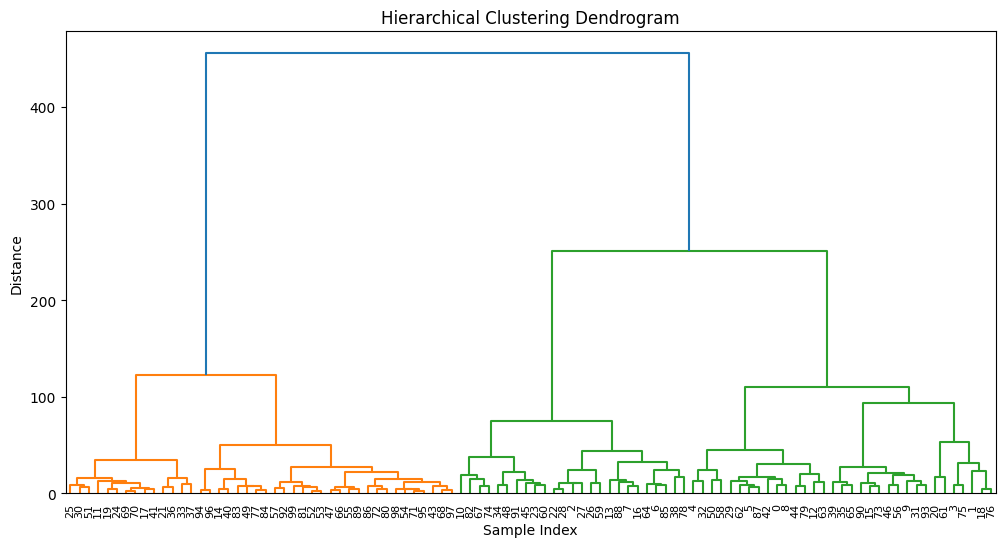

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import BisectingKMeans
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import numpy as np

# Create a SparkSession
spark = SparkSession.builder \
    .appName("NBA Hierarchical Clustering") \
    .getOrCreate()

# Load the dataset
df = spark.read.csv("/content/Book1.csv", header=True, inferSchema=True)

# Selecting relevant columns for clustering
selected_columns = ["Age", "G", "GS", "MP", "FG", "FGA", "FG%", "3P", "3PA", "3P%", "2P", "2PA", "2P%", "FT", "FTA", "FT%", "ORB", "DRB", "TRB", "AST", "STL", "BLK", "TOV", "PF", "PTS"]

# Drop any rows with missing values
df = df.dropna()

# Sample 100 rows
sampled_df = df.limit(100)

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=selected_columns, outputCol="features")
df = assembler.transform(sampled_df)

# Select the feature column
data = df.select("features")

# Initialize the hierarchical clustering model
bkmeans = BisectingKMeans(featuresCol="features", predictionCol="prediction", k=2)

# Train the hierarchical clustering model
bkmeans_model = bkmeans.fit(data)

# Make predictions
predictions = bkmeans_model.transform(data)

# Extract features from the Spark DataFrame and convert to NumPy array
features_array = np.array(data.select("features").rdd.map(lambda x: x[0]).collect())

# Perform hierarchical clustering using scipy
Z = linkage(features_array, method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 6))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90., leaf_font_size=8.)
plt.show()

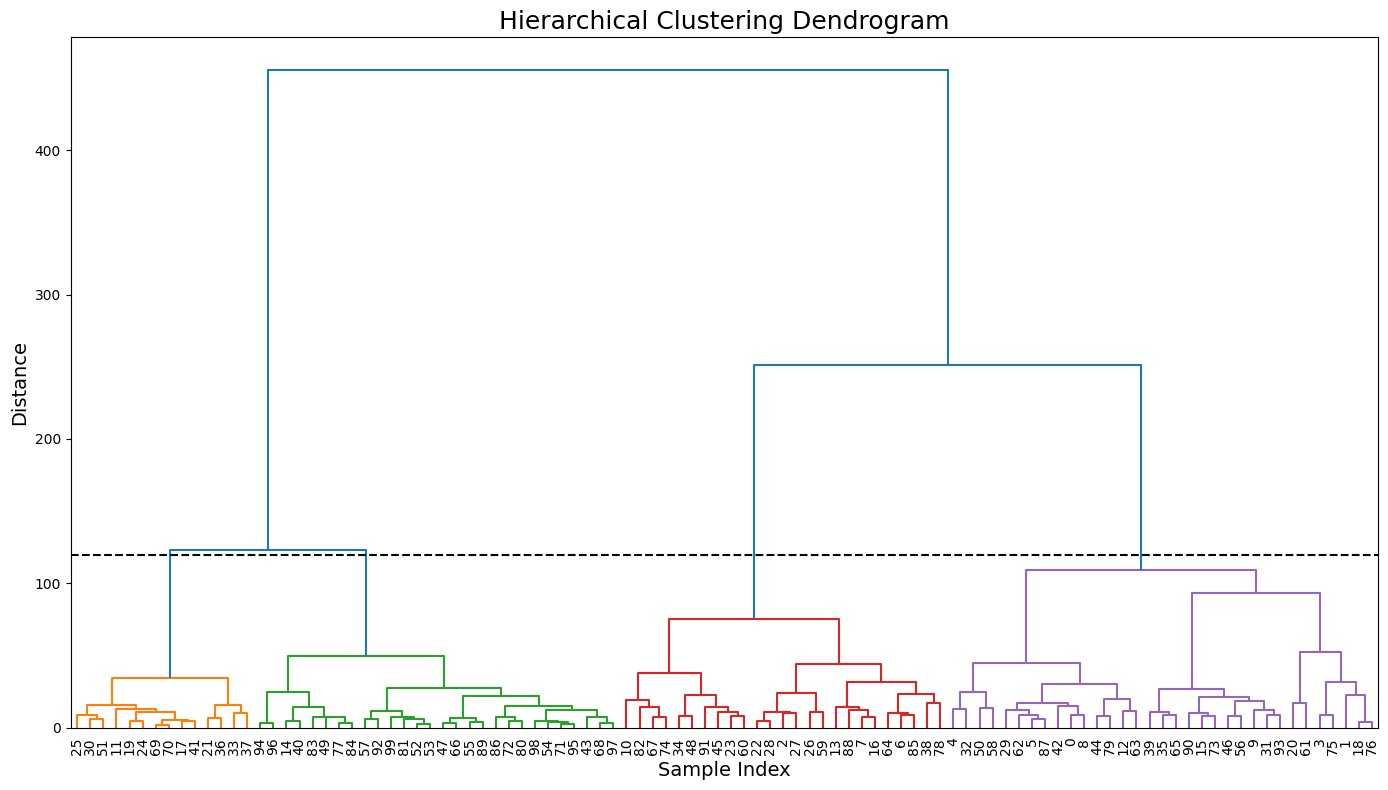

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import BisectingKMeans
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import numpy as np

# Create a SparkSession
spark = SparkSession.builder \
    .appName("NBA Hierarchical Clustering") \
    .getOrCreate()

# Load the dataset
df = spark.read.csv("/content/Book1.csv", header=True, inferSchema=True)

# Selecting relevant columns for clustering
selected_columns = ["Age", "G", "GS", "MP", "FG", "FGA", "FG%", "3P", "3PA", "3P%", "2P", "2PA", "2P%", "FT", "FTA", "FT%", "ORB", "DRB", "TRB", "AST", "STL", "BLK", "TOV", "PF", "PTS"]

# Drop any rows with missing values
df = df.dropna()

# Sample 100 rows
sampled_df = df.limit(100)

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=selected_columns, outputCol="features")
df = assembler.transform(sampled_df)

# Select the feature column
data = df.select("features")

# Initialize the hierarchical clustering model
bkmeans = BisectingKMeans(featuresCol="features", predictionCol="prediction", k=2)

# Train the hierarchical clustering model
bkmeans_model = bkmeans.fit(data)

# Make predictions
predictions = bkmeans_model.transform(data)

# Extract features from the Spark DataFrame and convert to NumPy array
features_array = np.array(data.select("features").rdd.map(lambda x: x[0]).collect())

# Perform hierarchical clustering using scipy
Z = linkage(features_array, method='ward')

# Plot dendrogram
plt.figure(figsize=(14, 8))
plt.title('Hierarchical Clustering Dendrogram', fontsize=18)
plt.xlabel('Sample Index', fontsize=14)
plt.ylabel('Distance', fontsize=14)
dendrogram(Z, leaf_rotation=90., leaf_font_size=10., color_threshold=120)
plt.axhline(y=120, color='k', linestyle='--', linewidth=1.5)  # Add threshold line
plt.tight_layout()  # Adjust layout
plt.show()


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Create a SparkSession
spark = SparkSession.builder \
    .appName("NBA SVM Classification") \
    .getOrCreate()

# Load the dataset
df = spark.read.csv("/content/Book1.csv", header=True, inferSchema=True)

# Selecting relevant columns for classification
selected_columns = ["2P", "2PA", "2P%", "FT", "FTA", "FT%"]

# Drop any rows with missing values
df = df.dropna()

from pyspark.sql.functions import when

# Convert '3PM' column into binary labels based on a threshold value
threshold = 1.4
df = df.withColumn("label", when(df["3P"] > threshold, 1).otherwise(0))

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=selected_columns, outputCol="features")
df = assembler.transform(df)

# Select the feature column and target variable
data = df.select("features", "label")

# Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Initialize the SVM model
svm = LinearSVC(featuresCol="features", labelCol="label")

# Train the SVM model
svm_model = svm.fit(train_data)

# Make predictions on the test data
predictions = svm_model.transform(test_data)

# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol="label")
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)


Accuracy: 0.8749329039184109


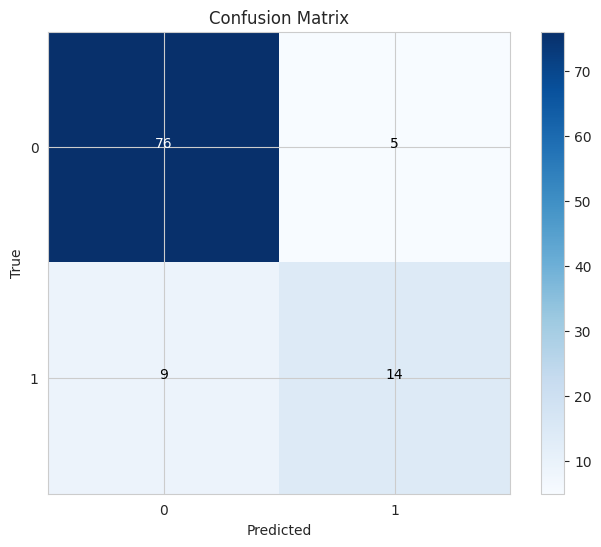

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import numpy as np

# Create confusion matrix
y_true = predictions.select("label").rdd.flatMap(lambda x: x).collect()
y_pred = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks([0, 1], ['0', '1'])
plt.yticks([0, 1], ['0', '1'])

for i in range(len(cm)):
    for j in range(len(cm)):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2. else "black")

plt.show()